# Radon example from Gelman and Hill (2006)
This is a reworking of the radon example from pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html


Other implementations in: 

- tensorflow https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer - pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html 

- stan https://mc-stan.org/users/documentation/case-studies/radon.html 

- pyro https://github.com/pyro-ppl/pyro-models/blob/master/pyro_models/arm/radon.py 

- numpyro fibrosis dataset http://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [1]:
import altair as alt
alt.renderers.enable('altair_saver', fmts=['png'])
from bayes_window import BayesWindow
from bayes_window.utils import load_radon
df = load_radon()

df

,county,radon,floor
0,0,2.2,1
1,0,2.2,0
2,0,2.9,0
3,0,1.0,0
4,1,3.1,0
...,...,...,...
922,83,6.4,0
923,83,4.5,0
924,83,5.0,0
925,84,3.7,0


In [2]:
window=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')

## Plot data

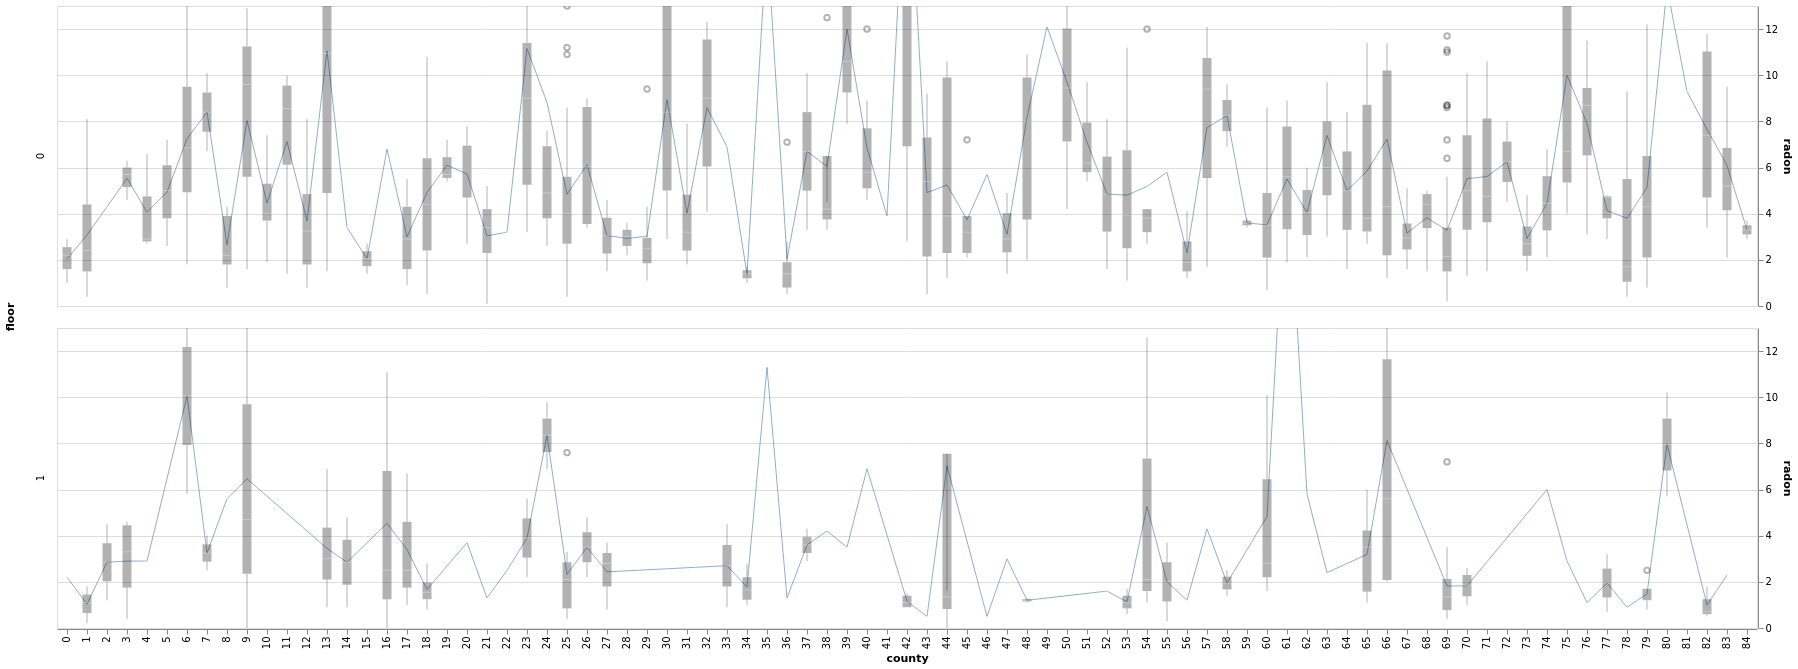

In [3]:
window.plot(x='county').facet(row='floor')

## Fit LME

Using formula radon ~  floor + (1 | county)
             Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept    5.493    0.525  10.464  0.000   4.464   6.522
floor       -2.289    0.388  -5.899  0.000  -3.050  -1.529
1 | county   0.005    0.011   0.450  0.653  -0.016   0.025
Group Var    2.852    0.207                               


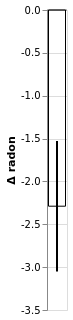

In [4]:
window.fit_lme()#formula='radon ~ floor + ( 1 | county)')

window.plot(add_data=False)

## Fit Bayesian hierarchical with and without county-specific intercept

In [5]:
window1=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window1.fit_slopes(add_group_intercept=True);



Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


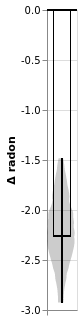

In [6]:
window1.plot(x=':O',add_data=False,)

TODO plot_intercept_with_details() 

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


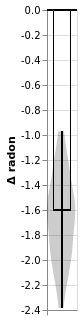

In [7]:
window2=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window2.fit_slopes(add_group_intercept=False, add_group_slope=False, do_make_change='subtract');

window2.plot(x=':O',add_data=False,)

## Compare the two models

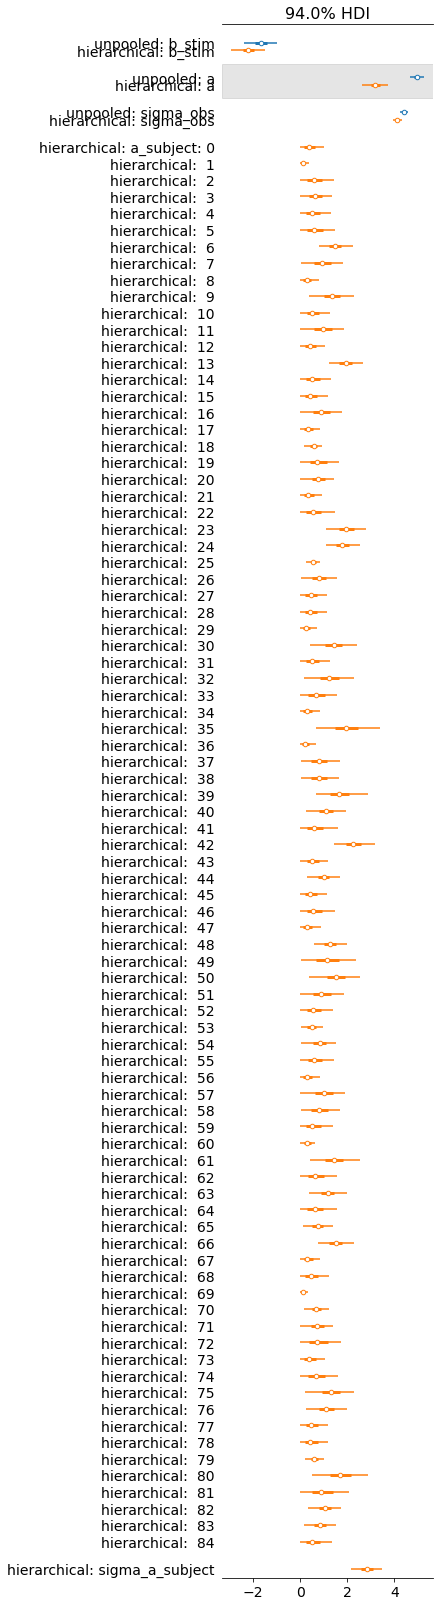

In [8]:
import arviz as az
datasets = {'unpooled' : window2.trace.posterior,
           'hierarchical': window1.trace.posterior} 

az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), 
               #backend='bokeh',
               #kind='ridgeplot',
               #ridgeplot_overlap=1.6,
               combined=True);



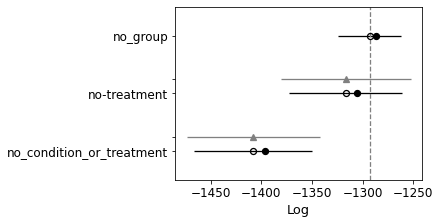

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
no_group,0,-1292.987379,5.875669,0.000000,0.553847,31.343991,0.000000,False,log
no-treatment,1,-1316.788048,11.123380,23.800669,0.446153,56.237486,64.306969,True,log
no_condition_or_treatment,2,-1408.131932,11.577629,115.144553,0.000000,58.525450,66.028487,True,log


In [9]:
from bayes_window.model_comparison import compare_models
self=window1
compare_models(df,y=self.y,parallel=True,
    models = {
#                 'full_normal': self.model,
                'no_condition_or_treatment': self.model,
                'no-treatment': self.model,
                'no_group': self.model,
#                 'full_student': self.model,
#                 'full_lognormal': self.model,
#                 'full_gamma': self.model,
#                 'full_exponential': self.model,
            },
            extra_model_args = [
#                 {'treatment': self.treatment, 'condition': self.condition, 'group': self.group},
                {'treatment': None, 'condition': None},
                {'treatment': None, 'condition': self.condition},
                {'treatment': self.treatment, 'group': None},
#                 {'treatment': self.treatment, 'condition': self.condition, 'group': self.group, 'dist_y': 'student'},
#                 {'treatment': self.treatment, 'condition': self.condition, 'group': self.group, 'dist_y': 'lognormal'},
#                 {'treatment': self.treatment, 'condition': self.condition, 'group': self.group, 'dist_y': 'gamma'},
#                 {'treatment': self.treatment, 'condition': self.condition, 'group': self.group,
#                  'dist_y': 'exponential'},
            ])

## References

  -  Gelman, A., & Hill, J. (2006), Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.), Cambridge University Press.
  -  Gelman, A. (2006), Multilevel (Hierarchical) modeling: what it can and cannot do, Technometrics, 48(3), 432–435.
  -  McElreath, R. (2020), Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.), CRC Press.

